Importing modules

In [33]:
import pandas as pd
import cv2
import os
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter

variables and directories

In [45]:
index=["color", "color_name", "hex", "R", "G", "B"]
csv = pd.read_csv('colors.csv', names=index, header=None)

number_of_colors = 3

loading haarcascades

In [35]:
face_cascade = cv2.CascadeClassifier('Haarcascade_files/haarcascade_frontalface_default.xml')
eye_cascade = cv2.CascadeClassifier('Haarcascade_files/haarcascade_eye.xml')

function for ROI of eyes

In [36]:
def ROI_for_eyes(eyes, img):
    for x,y,w,h in eyes:
        roi_eye_color = img[y+25:y+h-25, x+25:x+w-25]
        roi_eye_color = cv2.resize(roi_eye_color, (100, 100), interpolation = cv2.INTER_AREA)
        roi_eye_color_3D = roi_eye_color
        roi_eye_color = cv2.cvtColor(roi_eye_color, cv2.COLOR_BGR2RGB)
        roi_eye_color = roi_eye_color.reshape(roi_eye_color.shape[0]*roi_eye_color.shape[1], 3)
        break
    return roi_eye_color, roi_eye_color_3D

In [37]:
def RGB2HEX(color):
    return "#{:02x}{:02x}{:02x}".format(int(color[0]), int(color[1]), int(color[2]))

functions for detecting color in image

In [38]:
def recognize_color(R,G,B):
    minimum = 10000
    for i in range(len(csv)):
        d = abs(R- int(csv.loc[i,"R"])) + abs(G- int(csv.loc[i,"G"]))+ abs(B- int(csv.loc[i,"B"]))
        if(d<=minimum):
            minimum = d
            cname = csv.loc[i,"color_name"]
    return cname

In [39]:
def color_detector(eye, show_chart):
    counter = 0
    clf = KMeans(n_clusters = number_of_colors)
    labels = clf.fit_predict(eye)
    counts = Counter(labels)
    center_colors = clf.cluster_centers_
    # We get ordered colors by iterating through the keys
    ordered_colors = [center_colors[i] for i in counts.keys()]
    hex_colors = [RGB2HEX(ordered_colors[i]) for i in counts.keys()]
    rgb_colors = [ordered_colors[i] for i in counts.keys()]
    if (show_chart):
        plt.figure(figsize = (8, 6))
        plt.pie(counts.values(), labels = hex_colors, colors = hex_colors)
    for i in counts.values():
        if i == max(counts.values()):
            break
        counter += 1
    for color in rgb_colors:
        if counter != 0:
            counter -= 1
            continue
        print("Color:")
        print(recognize_color(color[0],color[1],color[2]))
        break

function for detecting face and eyes

In [40]:
def faces_and_eyes_detector(image):
    # Convert into grayscale and resize
    img = cv2.resize(image, None, fx = 1, fy = 1, interpolation = cv2.INTER_LINEAR)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Detect faces
    faces = face_cascade.detectMultiScale(gray, 1.8, 4)
    # extracting ROI for eyes
    if len(faces) == 0:
        roi_eyes_colour = img[:]
        roi_eyes_gray = gray[:]
    else:
        for x,y,w,h in faces:
            roi_eyes_gray = gray[y:y+h, x:x+w]
            roi_eyes_colour = img[y:y+h, x:x+w]
    # Detect eyes
    eyes = eye_cascade.detectMultiScale(roi_eyes_gray, 1.8, 4)
    display_img(img, roi_eyes_colour, faces, eyes, flag = 1)
    
    if len(eyes) != 0:
        roi_eye_color, roi_eye_color_3d = ROI_for_eyes(eyes, roi_eyes_colour)
        color_detector(roi_eye_color, True)
        cv2.imshow("eye",roi_eye_color_3d )
        cv2.waitKey()
        cv2.destroyWindow("eye")
    else:
        print("Eyes not Detected!!")

function to display detected face and eyes on image

In [41]:
def display_img(img, roi_eyes_colour, faces, eyes, flag = 0):
    # Draw rectangle around the faces
    for (x, y, w, h) in faces:
        cv2.rectangle(img, (x, y ), (x+w, y+h), (255, 0, 0), 1)
    # Draw rectangle around the eyes
    for (x, y, w, h) in eyes:
        if flag == 1:
            cv2.rectangle(roi_eyes_colour, (x, y+12), (x+w, y+h-12), (255, 255, 0), 1)
        else:
            cv2.rectangle(img, (x, y+12), (x+w, y+h-12), (255, 255, 0), 1)
    cv2.imshow('img', img)
    cv2.waitKey()
    cv2.destroyWindow('img')

function for taking picture

In [42]:
from tkinter import *
from tkinter import ttk
import random

def Picture():
    try:
        cam.release()
    except:
        print("opening camera!")
    cam = cv2.VideoCapture(0)
    while True:
        ret, frame = cam.read()
        if not ret:
            print("can't receive frame. Exiting...")
            break
        frame = cv2.flip(frame, 1)
        cv2.imshow("Picture", frame)
        if cv2.waitKey(1) == ord('f'):
            file_dir = "image"+str(random.randint(0,200))+".png"
            cv2.imwrite(file_dir, frame)
            print("Picture Taken!!")
            print("Closing Camera!!")
            cam.release()
            cv2.destroyWindow("Picture")
            current_image = cv2.imread(file_dir)
            faces_and_eyes_detector(current_image)
            break
        elif cv2.waitKey(1) == ord('q'):
            cv2.destroyWindow("Picture")
            break
    cam.release()

GUI

opening camera!
Picture Taken!!
Closing Camera!!
Color:
Dark Jungle Green


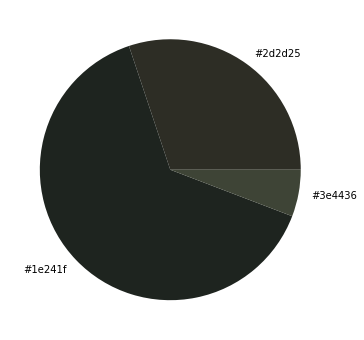

In [43]:
window = Tk()
window.title("Camera App")
mainframe = ttk.Frame(window, padding = "10 10 20 20")
mainframe.grid(column = 0, row = 0, sticky = (N, W, E, S))
window.columnconfigure(0, weight = 1)
window.rowconfigure(0, weight = 1)

ttk.Label(mainframe, text = "Take a picture to detect eye color").grid(padx = 50, pady = 10, column = 2, row = 1, sticky = N)
picture_button = ttk.Button(mainframe, text = "Open Camera", command = Picture).grid(padx = 50, pady = 30, column = 2, row = 2, sticky = N)
ttk.Label(mainframe, text = "Instructions").grid(padx = 50, pady = 5, column = 2, row = 3, sticky = N)
ttk.Label(mainframe, text = "1.Press 'F' to take pictures\n2.Press 'Q' to exit mode").grid(column = 1, row = 4, sticky = W, columnspan = 3)
window.mainloop()